This notebook uses data about births in the USA from [dataset](https://github.com/fivethirtyeight/data/tree/master/births) (the data is for births from 1994 to 2014) to explore interesting trends. The dataset is pretty detailed and has the number of births for *each* day; allowing for a more detailed analysis. 

The original data is in a CSV format and divided into two parts (1994-2003 and 2000-14). I combined these two files into one JSON file; a format that I find easier to deal with.

# Table of contents

1. [Births per year](#sec1) <br>
1.1 [The increase in births from 1999 to 2000](#sec1.1)
2. [How common is your birthday? Which date sees the most births?](#sec2)
3. [Which days are more popular?](#sec3)
4. [The curious case of Friday the 13th](#sec4) <br>
4.1 [How the other Fridays fare](#sec4.1)

In [37]:
#All the imports
import json
import csv
from pprint import pprint
import math
import matplotlib.pyplot as plt
from math import log as ln
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 7.5)
init_notebook_mode(connected=True)

Populating the interactive namespace from numpy and matplotlib


/Users/varungoel/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy



In [38]:
plot = True
data_dir = '../data/'
datafile = data_dir + 'data.json'

# 1. Births per year
<a id="sec1"></a>
It will be interesting to see how the number of births per year has changed over these 20 years. In 2017, the number of births hit a 30 year low and the fertility rate hit a record low of 60.2 births per 1000 women aged 15-44 ([source](http://fortune.com/2018/05/17/us-birth-rate-2017-fertility-economy/)). 



In [39]:
#gets the data for the number of births from 1994-2014 and plots them 
def get_yearly_births(datafile, plot=False):
	births = {str(i):0 for i in range(1994, 2015)}

	with open(datafile) as f:
		data = json.load(f)
		
		for year in data:
			year_births = 0
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for day in month_data:
					year_births += int(month_data[day]['births'])

			births[year] = year_births

	if plot:
		sum = 1000000
		births = {year:births[year]/sum for year in births}

		lists = sorted(births.items()) # sorted by key, return a list of tuples
		x, y = zip(*lists) # unpack a list of pairs into two tuples
		plt.plot(x, y,marker='o')
		plt.xlabel('Year')
		plt.ylabel('Births in million')
		plt.title('Yearwise births in USA')
		plt.ylim([3.1,5])
		plt.figure(figsize=(15,15))
		plt.show()

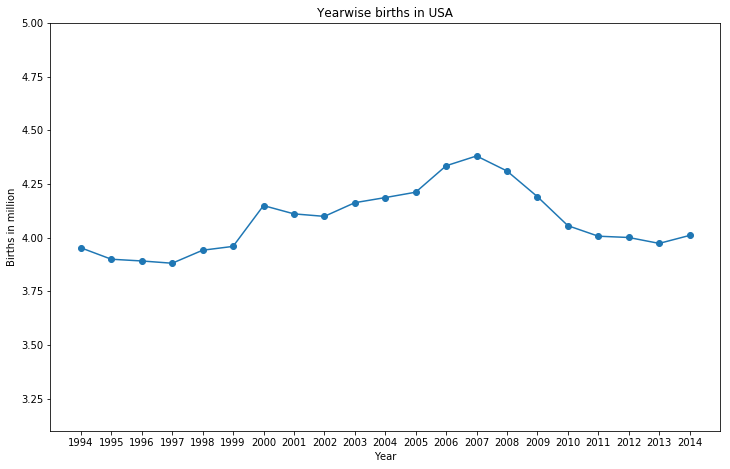

<Figure size 1080x1080 with 0 Axes>

In [40]:
get_yearly_births(datafile, plot)

**Figure 1: ** There are two interesting things to see in the figure:
1. There's a sharp increase in the number of births from the year 1999 to 2000. This has been explored in the figures below.
2. The sharp decline in births from 2007 to 2010 coincides with the financial crisis that lasted from 2008-9. From 2010-13, the number of births was still decreasing; however, at a much slower rate. There was a small increase from 2013-14. However, as explained above, the number of births has been declining since then till 2017 (when it hit a 30 year low).

## 1.1. The increase in births from 1999 to 2000
<a id="sec1.1"></a>

As seen in **Figure 1**, there was an increase in the number of births from 1999 to 2000. My initial belief was that a large chunk of this increase could be attributed to the conception of babies in November and December 1999 because of Thanksgiving, Christmas and New Year (in this case, the start of a new millenium) leading to more births in August and September. However, as seen in the plots below, this wasn't the case.

In [41]:
def get_year_distribution(datafile, year):
	year = str(year)
	with open(datafile) as f:
		data = json.load(f)
		data_year = data[year]

		if plot:
			births = {month:0 for month in data_year}
			for month in data_year:
				month_births = 0
				month_data = data_year[month]
				for date in month_data:
					month_births += month_data[date]['births']
				births[month] = month_births
			
			births = {int(month): births[month]/100000 for month in births}
			lists = sorted(births.items()) # sorted by key, return a list of tuples
			x, y = zip(*lists) # unpack a list of pairs into two tuples
			plt.plot(x, y,marker='o')
			plt.xlabel('Month')
			plt.ylabel('Births in hundred thousand')
			plt.title('Monthwise births in the year ' + str(year))
			plt.ylim([2.5,4])
			plt.show()
			return births                    

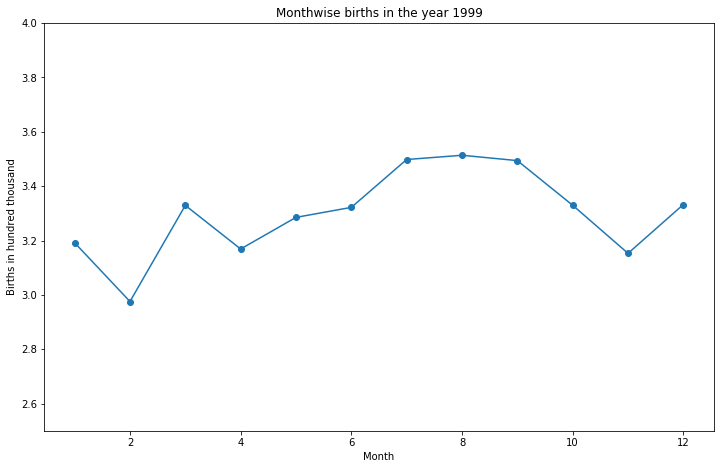

{1: 3.19182,
 2: 2.97568,
 3: 3.32939,
 4: 3.16889,
 5: 3.28526,
 6: 3.32201,
 7: 3.49812,
 8: 3.51371,
 9: 3.49409,
 10: 3.3298,
 11: 3.15289,
 12: 3.33251}

In [42]:
get_year_distribution(datafile, 1999)

**Figure 2 (top) and Figure 3 (below): ** There wasn't a *drastic* increase in births in August and September as I was expecting. February saw the largest gain. Overall, the increase was well distributed across all months.

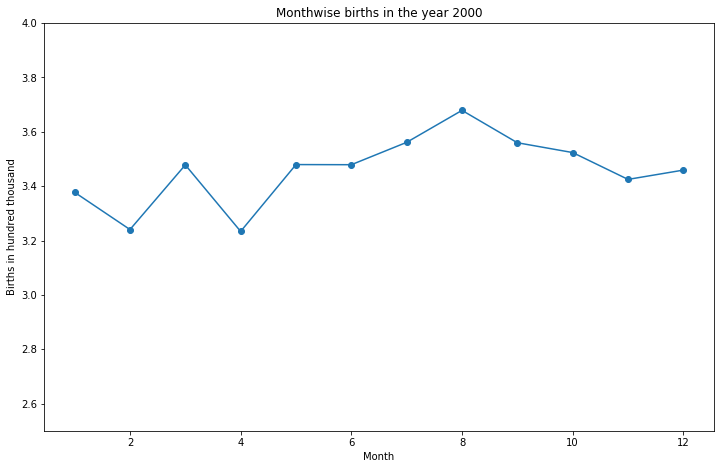

{1: 3.37739,
 2: 3.24046,
 3: 3.47824,
 4: 3.23357,
 5: 3.4795,
 6: 3.47899,
 7: 3.56131,
 8: 3.67893,
 9: 3.55981,
 10: 3.52368,
 11: 3.42494,
 12: 3.45916}

In [43]:
get_year_distribution(datafile, 2000)

# 2. How common is your birthday? Which date sees the most births?
<a id="sec2"></a>

Seeking inspiration from [GitHub's contribution graph](https://help.github.com/articles/viewing-contributions-on-your-profile/), I wanted to see which days are the 'busiest' in terms of number of births and if certain days are more/less favored for when parents do have a choice for the delivery date of their baby. All the data from 20 years was used for this part.

Ranking months based on total births is not as useful becuase some months have more days than others; leading to a higher absolute count even though the average births per day might be lower.

In [44]:
#get the daily birth info for all years and plot the heatmap
def get_combined_day_births(datafile):
	births = {i:0 for i in range(1, 367)}
	births = {month:{} for month in range(1, 13)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for date in month_data:
					if int(date) not in births[int(month)]:
						births[int(month)][int(date)] = 0
					births[int(month)][int(date)] += month_data[date]['births']

	months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
	date_list = [x for x in range(1, 32)]

	z = []
	i = 0

	rank_list = []

	for month in births:
		i += 1
		month_data = births[i]
		new_row = []
		for date in date_list:
			if date in month_data:
				new_row.append(month_data[date])
				rank_list.append(month_data[date])
			else:
				new_row.append(0)
				rank_list.append(0)
		z.append(new_row)

	#z[1][28] *= 4
	rank_list.sort()
	rank_list = rank_list[::-1]
    
	hovertext = list()
	for month in months:
		hovertext.append(list())
		month_data = z[months.index(month)]
		for date_val in date_list:
			birth_count = month_data[int(date_val) - 1]
			to_append = 'Month: ' + str(month) + '<br />Date: ' + str(date_val) + '<br />Births: ' + str(birth_count) + '<br />Rank: ' + str(rank_list.index(birth_count) + 1)
			hovertext[-1].append(to_append)

	data = [
	go.Heatmap(
		z=z,
		x=date_list,
		y=months,
		colorscale='Jet',
		hoverinfo='text',
		text=hovertext
		)
	]

	layout = go.Layout(
		title='Births per date from 1994-2014',
		xaxis = dict(ticks='', nticks=31),
		yaxis = dict(ticks='' )
	)

	fig = go.Figure(data=data, layout=layout)
	iplot(fig,show_link=False)# filename='datetime-heatmap')

In [45]:
get_combined_day_births(datafile)

**Figure 4:** Hover over your birthday in the plot above to see how it 'ranks' in terms of frequency! 9th September ranks 1st with 259,228 births. 

The anomalies are instantly recognizable. 29th February obviously ranks low. 4th July (Independence day), 31st October (Halloween), 24th-26th December (Christmas), 1st and 2nd January (New Year) all rank extremely low (> 350). Funnily enough, the days prior to and after Independence Day and Christmas are highly ranked; potentially indicating the parents who chose to (if it was possible) to not have their baby on a holiday.

14th February (Valentine's Day) doesn't rank as low. In fact, it is the most popular date in February! This could be due to that fact that the event is not as family oriented as the other holidays.

July to September are inarguably the busiest months; putting a conception date of October to December; overlapping with Halloween, Thanksgiving, Christmas and New Year holidays.

# 3. Which days are more popular?
<a id="sec3"></a>
Are certain days more popular in terms of number of births or is the number evenly distributed across all days?



In [46]:
def get_day_distribution(datafile):
	days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
	births = {i : 0 for i in range(1, 8)}
	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_births = 0
				month_data = year_data[month]
				for date in month_data:
					day = month_data[date]['day']
					births[int(day)] += month_data[date]['births']
		
		births = {days[i - 1] : births[i] for i in range(1, 8)}
		pprint(births)
		total = 1000000
		births = {day:(births[day]/total) for day in births}

		plt.xlabel('Day')
		plt.ylabel('Number of births (in millions)')
		plt.ylim([0,15])
		plt.title('Number of births by day in USA from 1994-2014')
		plt.bar(list(births.keys()), births.values())
		plt.show()

{'Friday': 13522413,
 'Monday': 12720974,
 'Saturday': 9449669,
 'Sunday': 8368365,
 'Thursday': 13744222,
 'Tuesday': 14074616,
 'Wednesday': 13832479}


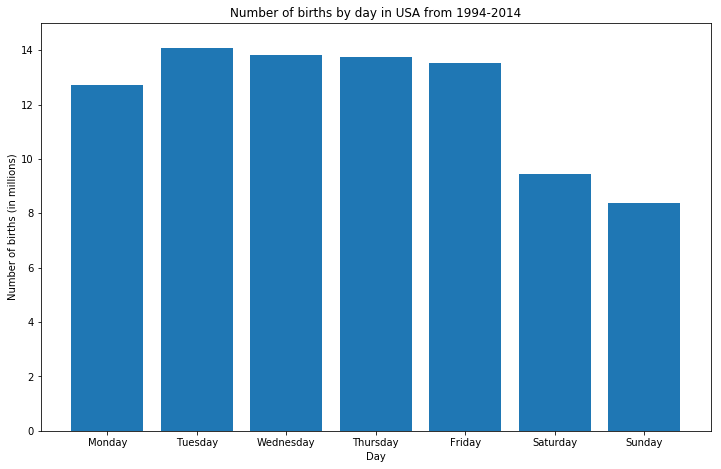

In [47]:
get_day_distribution(datafile)

**Figure 5:** Tuesdays saw the most births. There's a sharp decrease from the weekdays to Saturday and Sunday.

# 4. The curious case of Friday the 13th 
<a id="sec4"></a>
13 is considered as unlucky by many and [Friday the 13th](https://en.wikipedia.org/wiki/Friday_the_13th) is considered an unlucky day in Western superstition. How does that translate to babies being born? Given the choice, do parents choose not to have their baby on the 13th and, especially, on Friday the 13th?

My first instinct was to compare the number of births on 13th to the number of births on 12th and 14th (day before and day after). However, as seen in **Figure 5**, Saturdays and Sundays witness comparitively a lower number of births. So, for the 13th falling on Friday and Saturday, a comparitively lower value would be observed for the previous and next days. To move around this issue, I compared the number of births on 13th with the average of births on 6th and 20th for all days (Monday - Sunday). This ensured that the comparision was being made between the same days and the effect (if any) of Friday the 13th could be observed in a better manner.

In an ideal situation, the difference will be miniscule (+ve or -ve) because there will be a roughly uniform distribution. However, that is rarely the case! In a general observation of the heatmap in **Figure 4**, one can already see the the 13th in most of the months ranks pretty low. 

**Note:** This plot considers **all** births in the dataset.



In [48]:
def friday_thirteen_special(datafile, val1 = 6, val2 = 20):
	days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
	#store info about births on date val1. Each key is the day that the 13th was
	prev = {i : 0 for i in range(1, 8)}
	#info about 13th
	thirteenth = {i : 0 for i in range(1, 8)}
	#info about date val2
	next_ = {i : 0 for i in range(1, 8)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for date in month_data:
					#only considering the 13th of every month
					day = month_data['13']['day']
					if int(date) == val1 or int(date) == 13 or int(date) == val2:
						date_data = month_data[date]
						births = month_data[date]['births']
						if int(date) == val1:
							prev[int(day)] += births
						elif int(date) == 13:
							thirteenth[int(day)] += births
						elif int(date) == val2:
							next_[int(day)] += births
	avgs = [((prev[i] + next_[i])/2) - thirteenth[i] for i in range(1, 8)]
	avgs_dict = {days[i]:-avgs[i]/10000 for i in range(0, 7)}
	pprint('6th: ' + str({days[i-1]: prev[i] for i in range(1, 8)}))
	pprint('13th: ' + str({days[i-1]: thirteenth[i] for i in range(1, 8)}))
	pprint('20th: ' + str({days[i-1]: next_[i] for i in range(1, 8)}))
	print()
	pprint(avgs_dict)
	plt.ylabel('Difference (in ten thousand)')
	plt.title('Difference in the number of births on 13th and average number of births on 6th and 20th across all years')
	plt.xlabel('Day')
	plt.bar(list(avgs_dict.keys()), avgs_dict.values())
    
	fig_size = plt.rcParams["figure.figsize"]
 
	fig_size[0] = 12
	fig_size[1] = 7.5
	plt.rcParams["figure.figsize"] = fig_size

	plt.ylim([-5,0])
	plt.show()

("6th: {'Monday': 397465, 'Tuesday': 456333, 'Wednesday': 446282, 'Thursday': "
 "480634, 'Friday': 434851, 'Saturday': 310039, 'Sunday': 282044}")
("13th: {'Monday': 400100, 'Tuesday': 454679, 'Wednesday': 434871, 'Thursday': "
 "467785, 'Friday': 411054, 'Saturday': 309333, 'Sunday': 279634}")
("20th: {'Monday': 418600, 'Tuesday': 472497, 'Wednesday': 449290, 'Thursday': "
 "487237, 'Friday': 443306, 'Saturday': 312806, 'Sunday': 282909}")

{'Friday': -2.80245,
 'Monday': -0.79325,
 'Saturday': -0.20895,
 'Sunday': -0.28425,
 'Thursday': -1.61505,
 'Tuesday': -0.9736,
 'Wednesday': -1.2915}


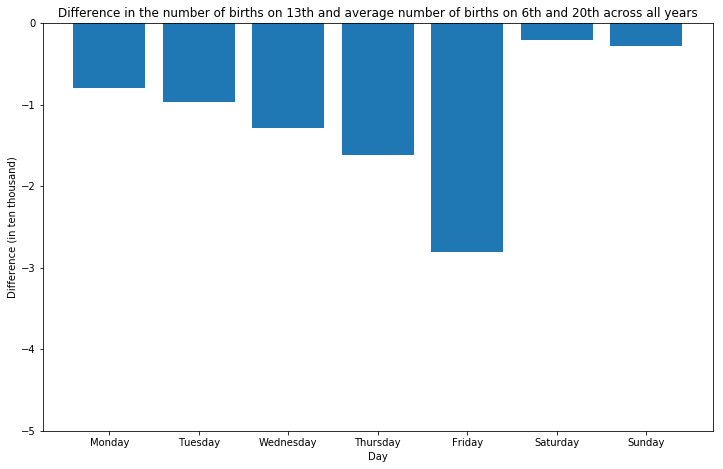

In [49]:
friday_thirteen_special(datafile)

**Figure 6:** There's a definite difference between the number of births on 13th and the average number of births on 6th and 20th. Saturday and Sundays see the smallest difference. But that's because these days themselves, don't see a lot of births (**Figure 5**). Friday the 13th *does* show a significant drop in number of births over Friday the 6th and 20th; adding up to more than 28,000 over the 20 years.

## 4.1 How the other Fridays fare
<a id="sec4.1"></a>

It'll be interesting to see how the *other* Fridays are in comparison with Friday the 13th. An important thing to note here is that taking absolute birth counts for each date will lead to spurious results; the date 31st doesn't occur as frequently as dates 1-28. To counter this, I considered the average number of births for each day across the 20 years. This leads to a fairer and more sensible comparison. 

After the mean number of births was found across all Fridays, I compared that value to the mean for each day to see which Fridays were more/less busy than the mean.

In [50]:
def compare_fridays(datafile):
	births = {i : 0 for i in range(1, 32)}
	counts = {i : 0 for i in range(1, 32)}

	with open(datafile) as f:
		data = json.load(f)

		for year in data:
			year_data = data[year]
			for month in year_data:
				month_data = year_data[month]
				for date in month_data:
					day = month_data[date]['day']
					if day == 5:
						num_births = month_data[date]['births']
						births[int(date)] += num_births
						counts[int(date)] += 1

	avgs_dict = {i : (births[i]/counts[i]) for i in range(1, 32)}
	mean = sum(list(avgs_dict.values()))/len(avgs_dict)
	avgs_dict = {i : avgs_dict[i] - mean for i in range(1, 32)}
	plt.ylabel('Number of births')
	plt.title('Comparison of mean number of births on Fridays of each date to the global mean of Friday births')
	plt.xlabel('Date')
	plt.bar(list(avgs_dict.keys()), avgs_dict.values())
	plt.ylim([-800,800])
	plt.show()

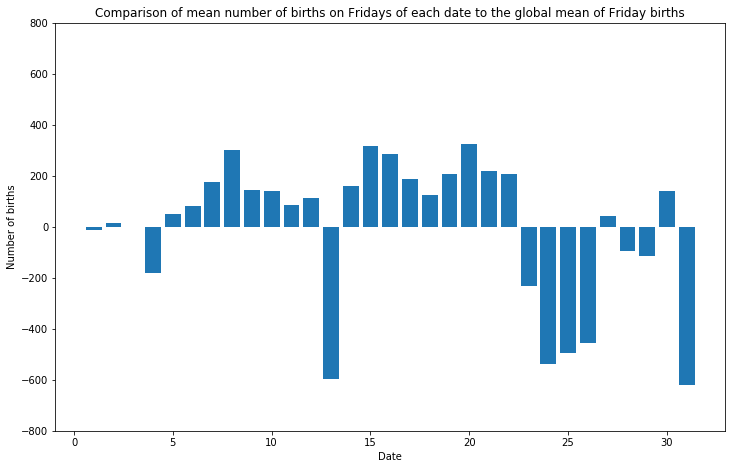

In [51]:
compare_fridays(datafile)

**Figure 7:** The 13th *does* show a significant drop in number of births in comparison to other Fridays. Roughly, 600 less babies are born on Friday the 13th than other Fridays. <br> The 31st came as a surprise to me; witnessing even lesser births than 13th. This, despite the fact that the average number of births was taken. In terms of absolute count, 31st was expected to fare lower because of a lesser amount of 31st days.